In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers

# Library for Transfer Learning
from tensorflow.keras.applications import resnet50

print("Importing libraries completed.")

Importing libraries completed.


In [4]:
main_folder="input/plantvillage"
class_names=os.listdir(main_folder)
print(class_names)

# Validation Dataset
validation_folder="input/Validation_Data"
val_class_names=os.listdir(validation_folder)
print(val_class_names)

['BrownSpot', 'Hispa', 'LeafBlast']
['BrownSpot', 'Hispa', 'LeafBlast']


# Preparation of Training Data

In [5]:
import time as T
x=[]
y=[]
begin = T.time()
for folder in os.listdir(main_folder):
    image_list=os.listdir(main_folder+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(main_folder+"/"+folder+"/"+img_name,target_size=(224,224))
        
        # Converting to arrary
        img=image.img_to_array(img)
        
        img=resnet50.preprocess_input(img) #  Optional step
        
        # Appending the arrarys
        x.append(img) # appending image array
        y.append(class_names.index(folder)) # appending class index to the array
end = T.time()      
print("Preparing Training Dataset Completed. Time taken: - ",end - begin," seconds")

Preparing Training Dataset Completed. Time taken: -  139.92524218559265  seconds


# Preparation of Testing Data

In [6]:
val_images=[]
val_image_label=[] # to store the labels of the images
begin=T.time()

for folder in os.listdir(validation_folder):
    image_list=os.listdir(validation_folder+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(validation_folder+"/"+folder+"/"+img_name,target_size=(224,224))
        
        # Converting to arrarys
        img=image.img_to_array(img)

        # Transfer Learning: this is to apply preprocess of resnet to our images before passing it to resnet
        img=resnet50.preprocess_input(img) #  Optional step
        
        # Appending arrays
        val_images.append(img) # appending image array
        val_image_label.append(val_class_names.index(folder))
end = T.time()        
print("Preparing Validation Dataset Completed. Time taken: - ",end-begin," seconds")

Preparing Validation Dataset Completed. Time taken: -  28.69773817062378  seconds


In [7]:
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)


# Validation Dataset
print("Validation Dataset")

val_images=np.array(val_images) 
print(val_images.shape)

val_image_label=to_categorical(val_image_label) # onehot encoding of the labels)
print(val_image_label.shape)

Training Dataset
(966, 224, 224, 3)
(966, 3)
Validation Dataset
(234, 224, 224, 3)
(234, 3)


# Building a Model: Using Transfer Learning

In [8]:
print("Summary of default ResNet50 model.\n")

# we are using resnet50 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import resnet50

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_resnet=resnet50.ResNet50(weights='imagenet')

# display the summary to see the properties of the model
model_resnet.summary()

Summary of default ResNet50 model.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________

In [9]:
print("Summary of Custom ResNet50 model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3)
input_layer=layers.Input(shape=(224,224,3))

# initialize the transfer model ResNet50 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the ResNet50 using input_tensor
# 3) we want to change the last layer so we are not including top layer
resnet_model=resnet50.ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
resnet_model.summary()

Summary of Custom ResNet50 model.

1) We setup input layer and 2) We removed top (last) layer. 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]            

In [10]:
print("Summary of Custom ResNet50 model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=resnet_model.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 

# Add dense layer
# dense1=layers.Dense(100,activation='relu')(flatten)

# Add dense layer to the final output layer
output_layer=layers.Dense(3,activation='softmax')(flatten)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

Summary of Custom ResNet50 model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]   

In [11]:
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-1]:
    layer.trainable=False
model.summary()

We are making all the layers intrainable except the last layer. 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________

conv4_block2_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_relu (Activation (None, 14, 14, 256)  0           conv4_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

In [12]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=5)
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

print("Splitting data for train and test completed.")

(772, 224, 224, 3)
(194, 224, 224, 3)
(772, 3)
(194, 3)
Splitting data for train and test completed.


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print("Model compilation completed.")

Model compilation completed.


In [12]:
# Fit the Model

model.fit(xtrain,ytrain,epochs=3,batch_size=32,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


Epoch 1/3
25/25 [==============================] - 74s 3s/step - loss: 12.3898 - accuracy: 0.4815 - val_loss: 8.6338 - val_accuracy: 0.6289
Epoch 2/3
25/25 [==============================] - 63s 3s/step - loss: 3.0350 - accuracy: 0.7818 - val_loss: 6.4749 - val_accuracy: 0.6495
Epoch 3/3
25/25 [==============================] - 65s 3s/step - loss: 0.7352 - accuracy: 0.8918 - val_loss: 6.6484 - val_accuracy: 0.6237
Fitting the model completed.


In [13]:
# Fit the Model

model.fit(xtrain,ytrain,epochs=3,batch_size=32,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


Epoch 1/3
25/25 [==============================] - 65s 3s/step - loss: 0.5226 - accuracy: 0.9249 - val_loss: 5.5869 - val_accuracy: 0.6598
Epoch 2/3
25/25 [==============================] - 66s 3s/step - loss: 0.2744 - accuracy: 0.9689 - val_loss: 8.0940 - val_accuracy: 0.5773
Epoch 3/3
25/25 [==============================] - 69s 3s/step - loss: 0.3500 - accuracy: 0.9611 - val_loss: 5.6316 - val_accuracy: 0.6753
Fitting the model completed.


In [14]:
# Fit the Model

model.fit(xtrain,ytrain,epochs=2,batch_size=32,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


Epoch 1/2
25/25 [==============================] - 76s 3s/step - loss: 0.9710 - accuracy: 0.9119 - val_loss: 8.0706 - val_accuracy: 0.6392
Epoch 2/2
25/25 [==============================] - 82s 3s/step - loss: 2.6505 - accuracy: 0.8510 - val_loss: 10.8681 - val_accuracy: 0.6701
Fitting the model completed.


In [15]:
# Fit the Model

model.fit(xtrain,ytrain,epochs=2,batch_size=32,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


Epoch 1/2
25/25 [==============================] - 80s 3s/step - loss: 0.7691 - accuracy: 0.9378 - val_loss: 9.0086 - val_accuracy: 0.7010
Epoch 2/2
25/25 [==============================] - 74s 3s/step - loss: 0.1371 - accuracy: 0.9832 - val_loss: 7.5766 - val_accuracy: 0.6907
Fitting the model completed.


In [16]:
# Fit the Model

model.fit(xtrain,ytrain,epochs=1,batch_size=32,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


25/25 [==============================] - 70s 3s/step - loss: 0.1185 - accuracy: 0.9793 - val_loss: 8.6549 - val_accuracy: 0.6753
Fitting the model completed.


In [17]:
# Fit the Model

model.fit(xtrain,ytrain,epochs=1,batch_size=32,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


25/25 [==============================] - 73s 3s/step - loss: 0.0551 - accuracy: 0.9909 - val_loss: 8.3794 - val_accuracy: 0.7062
Fitting the model completed.


In [18]:
scores = model.evaluate(xtest, ytest, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

7/7 [==============================] - 14s 2s/step - loss: 8.3794 - accuracy: 0.7062
Test loss: 8.37944221496582
Test accuracy: 0.7061855792999268


# Prediction on Random sample images

In [42]:
def predict(img):
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=resnet50.preprocess_input(img)
    prediction=model.predict(img.reshape(1,224,224,3))
    output=np.argmax(prediction)
    print("Predicted Value: -",class_names[output])

True value: -  BrownSpot_1.jpg


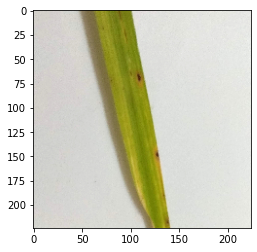

Predicted Value: - BrownSpot
--------------------------------------->>>>>>
True value: -  BrownSpot_2.jpg


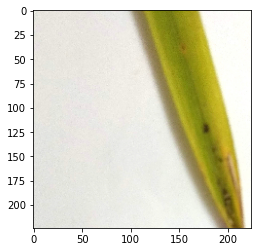

Predicted Value: - BrownSpot
--------------------------------------->>>>>>
True value: -  BrownSpot_3.jpg


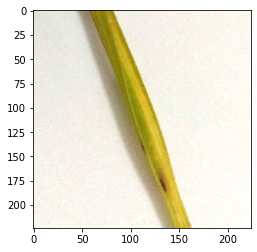

Predicted Value: - BrownSpot
--------------------------------------->>>>>>
True value: -  BrownSpot_4.jpg


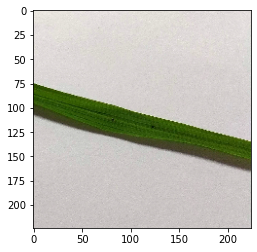

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  Hispa_1.jpg


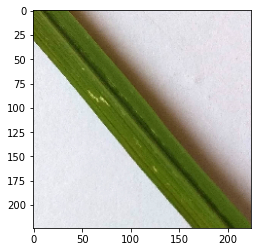

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  Hispa_2.jpg


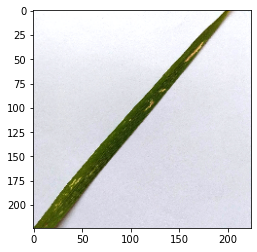

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  Hispa_3.jpg


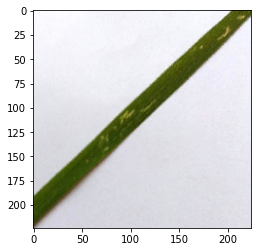

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  Hispa_4.jpg


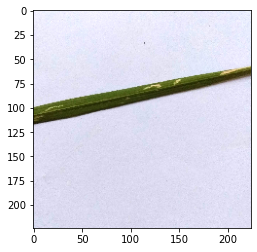

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  LeafBlast_1.jpg


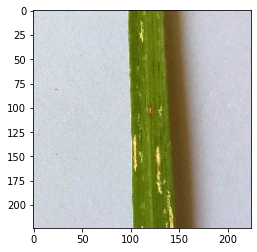

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  LeafBlast_2.jpg


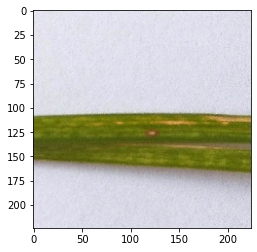

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  LeafBlast_3.jpg


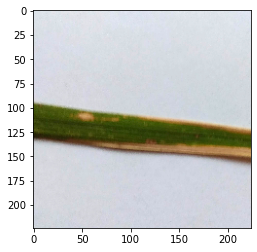

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  LeafBlast_4.jpg


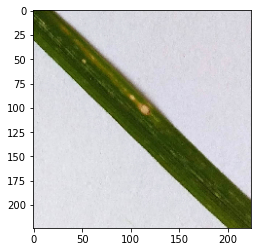

Predicted Value: - Hispa
--------------------------------------->>>>>>


In [44]:
testing_dir = "Testing_images"
true_labels = os.listdir(testing_dir)
for img_name in true_labels:
    img=image.load_img(testing_dir+"/"+img_name,target_size=(224,224))
    print("True value: - ", img_name)
    predict(img)
    print("--------------------------------------->>>>>>")

In [46]:
model.save('Plant_Disease_Detector.h5')

In [1]:
from keras.models import load_model
model_loaded = load_model('Plant_Disease_Detector.h5')

In [49]:
def predict_from_loaded_model(img):
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=resnet50.preprocess_input(img)
    prediction=model_loaded.predict(img.reshape(1,224,224,3))
    output=np.argmax(prediction)
    print("Predicted Value: -",class_names[output])

True value: -  BrownSpot_1.jpg


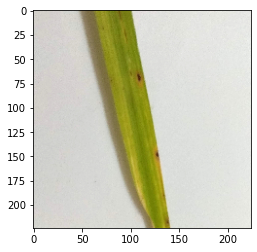

Predicted Value: - BrownSpot
--------------------------------------->>>>>>
True value: -  BrownSpot_2.jpg


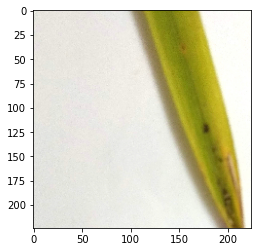

Predicted Value: - BrownSpot
--------------------------------------->>>>>>
True value: -  BrownSpot_3.jpg


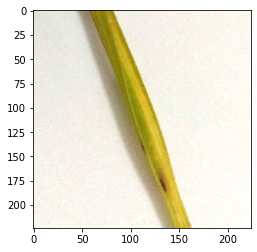

Predicted Value: - BrownSpot
--------------------------------------->>>>>>
True value: -  BrownSpot_4.jpg


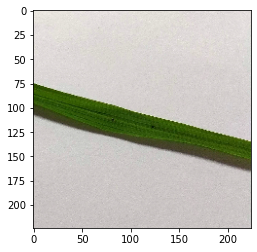

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  Hispa_1.jpg


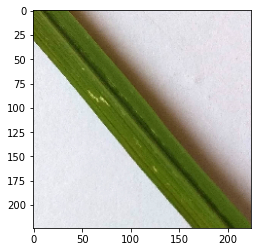

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  Hispa_2.jpg


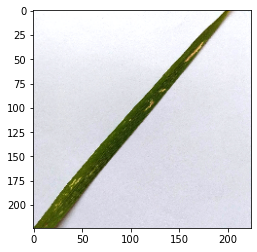

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  Hispa_3.jpg


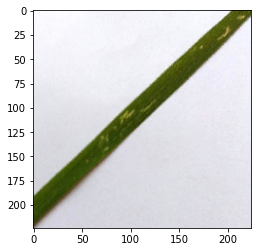

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  Hispa_4.jpg


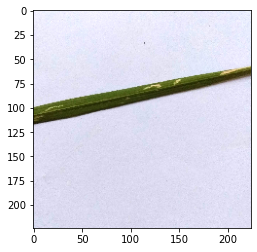

Predicted Value: - Hispa
--------------------------------------->>>>>>
True value: -  LeafBlast_1.jpg


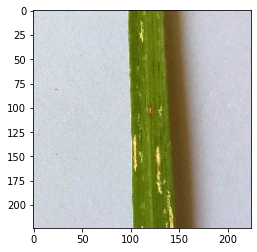

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  LeafBlast_2.jpg


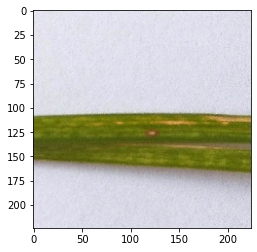

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  LeafBlast_3.jpg


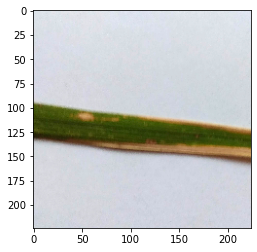

Predicted Value: - LeafBlast
--------------------------------------->>>>>>
True value: -  LeafBlast_4.jpg


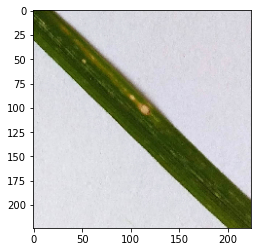

Predicted Value: - Hispa
--------------------------------------->>>>>>


In [50]:
testing_dir = "Testing_images"
true_labels = os.listdir(testing_dir)
for img_name in true_labels:
    img=image.load_img(testing_dir+"/"+img_name,target_size=(224,224))
    print("True value: - ", img_name)
    predict_from_loaded_model(img)
    print("--------------------------------------->>>>>>")

In [14]:
model.fit(xtrain,ytrain,epochs=1,batch_size=32,verbose=True,shuffle = True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


25/25 [==============================] - 67s 3s/step - loss: 9.3780 - accuracy: 0.4991 - val_loss: 8.0037 - val_accuracy: 0.5670
Fitting the model completed.


In [15]:
model.fit(xtrain,ytrain,epochs=1,batch_size=32,verbose=True,shuffle = True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


25/25 [==============================] - 63s 3s/step - loss: 2.2803 - accuracy: 0.8122 - val_loss: 5.6174 - val_accuracy: 0.6495
Fitting the model completed.


In [16]:
history=model.fit(xtrain,ytrain,epochs=1,batch_size=32,verbose=True,shuffle = True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


25/25 [==============================] - 62s 3s/step - loss: 1.0057 - accuracy: 0.8886 - val_loss: 5.5949 - val_accuracy: 0.6856
Fitting the model completed.


In [18]:
history=model.fit(xtrain,ytrain,epochs=1,batch_size=32,verbose=True,shuffle = True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


25/25 [==============================] - 62s 2s/step - loss: 0.2643 - accuracy: 0.9560 - val_loss: 5.7268 - val_accuracy: 0.6856
Fitting the model completed.


In [19]:
history=model.fit(xtrain,ytrain,epochs=5,batch_size=32,verbose=True,shuffle = True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


Epoch 1/5
25/25 [==============================] - 64s 3s/step - loss: 1.0027 - accuracy: 0.9054 - val_loss: 6.3806 - val_accuracy: 0.6443
Epoch 2/5
25/25 [==============================] - 65s 3s/step - loss: 0.9303 - accuracy: 0.9184 - val_loss: 8.0763 - val_accuracy: 0.6649
Epoch 3/5
25/25 [==============================] - 63s 3s/step - loss: 0.5096 - accuracy: 0.9495 - val_loss: 6.7402 - val_accuracy: 0.6598
Epoch 4/5
25/25 [==============================] - 63s 3s/step - loss: 0.0997 - accuracy: 0.9832 - val_loss: 6.1916 - val_accuracy: 0.6804
Epoch 5/5
25/25 [==============================] - 63s 3s/step - loss: 0.0232 - accuracy: 0.9922 - val_loss: 6.4132 - val_accuracy: 0.6856
Fitting the model completed.


In [20]:
history=model.fit(xtrain,ytrain,epochs=5,batch_size=32,verbose=True,shuffle = True,validation_data=(xtest,ytest))

print("Fitting the model completed.")


Epoch 1/5
25/25 [==============================] - 64s 3s/step - loss: 0.0208 - accuracy: 0.9948 - val_loss: 7.7704 - val_accuracy: 0.7165
Epoch 2/5
25/25 [==============================] - 64s 3s/step - loss: 0.0248 - accuracy: 0.9896 - val_loss: 6.9371 - val_accuracy: 0.6649
Epoch 3/5
25/25 [==============================] - 63s 3s/step - loss: 0.0116 - accuracy: 0.9987 - val_loss: 7.0205 - val_accuracy: 0.6804
Epoch 4/5
25/25 [==============================] - 64s 3s/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 6.8507 - val_accuracy: 0.6649
Epoch 5/5
25/25 [==============================] - 63s 3s/step - loss: 0.0287 - accuracy: 0.9935 - val_loss: 6.8953 - val_accuracy: 0.7010
Fitting the model completed.


In [ ]:
print(history.history.keys())

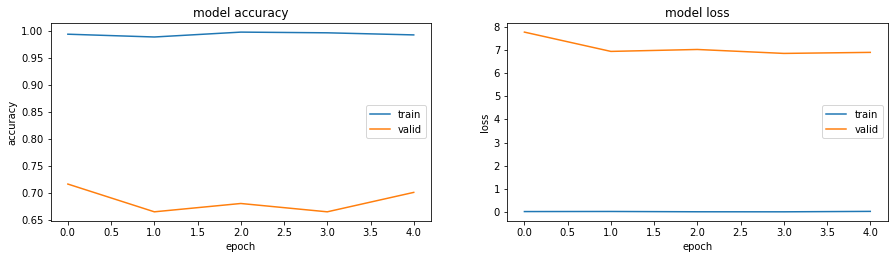

In [25]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()